# 马尔科夫链：基本概念

```{index} single: 马尔科夫链：基本概念和稳定性
```

除了 Anaconda 中已有的库外，本讲座还需要以下库：

In [1]:
!pip install quantecon


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


图像输入功能：启用

## 概览

马尔科夫链是一种标准方法，用于建模在时间序列中具有某些依赖关系的观察。

例如，

* 明年的通货膨胀取决于今年的通货膨胀
* 下个月的失业率取决于这个月的失业率

马尔科夫链是经济学和金融学中的常用模型之一。

马尔科夫链的理论非常美妙，提供了许多关于概率和动态的见解。

在这节介绍性讲座中，我们将

* 回顾一些马尔科夫链理论的关键思想，
* 展示马尔科夫链在一些经济应用中的出现。

让我们从一些标准的导入开始：

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
import networkx as nx
from matplotlib import cm
import matplotlib as mpl

图像输入功能：启用

## 定义和示例

在本节中，我们提供基本定义和一些初级示例。

(finite_dp_stoch_mat)=
### 随机矩阵

回顾一下，**概率质量函数**指的是$n$个可能结果中的一个非负$n$向量$p$，其总和为1。

例如，$p = (0.2, 0.2, 0.6)$是一个关于3个结果的概率质量函数。

**随机矩阵**（或**马尔科夫矩阵**）是一个$n \times n$的方阵$P$，使得$P$的每一行都是n个结果的概率质量函数。

换句话说，

1. $P$的每一个元素都是非负的，并且
1. $P$的每一行的总和为1。

如果$P$是一个随机矩阵，那么对于所有$k \in \mathbb N$，$P$的$k$次方$P^k$也是一个随机矩阵。

在下面的{ref}`第一组练习<mc1_ex_3>`中检查这一点。

### 马尔科夫链

现在我们可以介绍马尔科夫链了。

首先我们会给出一些示例，然后我们会更仔细地定义它们。

到那时，随机矩阵和马尔科夫链之间的连接就会变得清晰。

(mc_eg2)=
#### 示例 1

从美国失业数据中，Hamilton {cite}`Hamilton2005` 估计了以下动态。

```{image} /_static/lecture_specific/markov_chains_I/Hamilton.png
:name: mc_hamilton
:align: center
```

这里有三个**状态**

* "ng" 代表正常增长
* "mr" 代表轻度衰退
* "sr" 代表严重衰退

箭头表示一个月内的**转移概率**。

例如，从轻度衰退到正常增长的箭头旁有 0.145。

这告诉我们，根据过去的数据，从轻度衰退到正常增长的概率在一个月内是14.5%。

从正常增长到正常增长的箭头告诉我们，从正常增长到正常增长（保持在同一状态）的概率是97%。

注意这些是*条件*概率 --- 从一个状态转移到另一个状态（或保持在同一状态）的概率，条件是当前状态。

为了使问题更易于数值处理中，让我们将状态转换为数字。

特别地，我们约定

* 状态0代表正常增长
* 状态1代表轻度衰退
* 状态2代表严重衰退

令$X_t$记录时间$t$时的状态值。

现在我们可以将“从轻度衰退到正常增长在一个月内的转移概率为14.5%”写作

$$
    \mathbb P\{X_{t+1} = 0 \,|\, X_t = 1\} = 0.145
$$

我们可以将所有这些条件概率收集到一个矩阵中，如下所示

$$
P =
\begin{bmatrix}
0.971 & 0.029 & 0 \\
0.145 & 0.778 & 0.077 \\
0 & 0.508 & 0.492
\end{bmatrix}
$$

注意$P$是一个随机矩阵。

现在我们有了以下关系

$$
    P(i,j)
    = \mathbb P\{X_{t+1} = j \,|\, X_t = i\}
$$

这适用于所有的$i,j$在0到2之间。

特别地，$P(i,j)$是从状态$i$转移到状态$j$在一个月内的概率。

(mc_eg1)=
#### 示例 2

考虑一个工人，在任意给定时间 $t$，要么失业（状态 0）
要么就业（状态 1）。

假设在一个月期间，

1. 失业的工人找到工作的概率为 $\alpha \in (0, 1)$。
1. 就业的工人失去工作并成为失业者的概率为 $\beta \in (0, 1)$。

根据上述信息，我们可以将转移概率写成矩阵形式

```{math}
:label: p_unempemp

P =
\begin{bmatrix}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{bmatrix}
```

例如，

$$
\begin{aligned}
    P(0,1)
        & =
        \text{ 从状态 $0$ 转移到状态 $1$ 在一个月内的概率}
        \\
        & =
        \text{ 下个月找到工作的概率}
        \\
        & = \alpha
\end{aligned}
$$

假设我们可以估计 $\alpha$ 和 $\beta$ 的值。

那么我们可以解决一系列问题，例如

* 平均失业时间是多久？
* 从长远来看，工人失业的时间占比是多少？
* 在就业的条件下，未来12个月内至少一次失业的概率是多少？

我们将在下面介绍一些这些应用。

(mc_eg3)=
#### 示例 3

Imam和Temple {cite}`imampolitical` 将政治制度分类为
三类：民主 $\text{(D)}$、专制 $\text{(A)}$ 和一种中间状态称为无政府状态 $\text{(N)}$。

每个制度可以有两种潜在的发展方式：崩溃 $\text{(C)}$ 和增长 $\text{(G)}$。这导致了六种可能的状态：$\text{DG, DC, NG, NC, AG}$ 和 $\text{AC}$。

Imam和Temple {cite}`imampolitical` 估计了以下转移
概率：

$$
P :=
\begin{bmatrix}
0.86 & 0.11 & 0.03 & 0.00 & 0.00 & 0.00 \\
0.52 & 0.33 & 0.13 & 0.02 & 0.00 & 0.00 \\
0.12 & 0.03 & 0.70 & 0.11 & 0.03 & 0.01 \\
0.13 & 0.02 & 0.35 & 0.36 & 0.10 & 0.04 \\
0.00 & 0.00 & 0.09 & 0.11 & 0.55 & 0.25 \\
0.00 & 0.00 & 0.09 & 0.15 & 0.26 & 0.50
\end{bmatrix}
$$

In [3]:
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]

这些状态和转移概率可以用有向图（图论中的术语）表示为

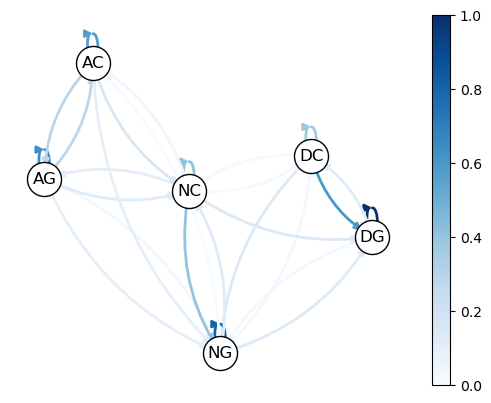

In [4]:
G = nx.MultiDiGraph()
edge_ls = []
label_dict = {}

for start_idx, node_start in enumerate(nodes):
    for end_idx, node_end in enumerate(nodes):
        value = P[start_idx][end_idx]
        if value != 0:
            G.add_edge(node_start,node_end, weight=value, len=100)

pos = nx.spring_layout(G, seed=10)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, node_size=600, edgecolors='black', node_color='white')
nx.draw_networkx_labels(G, pos)

arc_rad = 0.2
curved_edges = [edge for edge in G.edges()]
edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle=f'arc3, rad = {arc_rad}', edge_cmap=cm.Blues, width=2,
    edge_color=[G[nodes[0]][nodes[1]][0]['weight'] for nodes in G.edges])

pc = mpl.collections.PatchCollection(edges, cmap=cm.Blues)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

其中较深的颜色表示较高的概率。

### 经济洞察

通过查看数据，我们发现民主政体的增长周期比独裁政体更持久（如独裁政体从增长到增长的转移概率较低所示）。

我们还可以发现从崩溃到增长的概率在民主政体中较高。

### 定义马尔科夫链

到目前为止，我们已经给出了马尔科夫链的示例，现在让我们更仔细地定义它们。

首先，假设 $S$ 是一个有限集合 $\{x_1, \ldots, x_n\}$，该集合有 $n$ 个元素。

集合 $S$ 被称为 **状态空间**，而 $x_1, \ldots, x_n$ 被称为 **状态值**。

在 $S$ 上的一个 **分布** $\psi$ 是一个长度为 $n$ 的概率质量函数，其中 $\psi(i)$ 是分配给状态 $x_i$ 的概率。

在 $S$ 上的一个 **马尔科夫链** $\{X_t\}$ 是一个在 $S$ 取值的随机变量序列，具有 **马尔科夫性质**。

这意味着，对于任意时间 $t$ 和任意状态 $y \in S$，

```{math}
:label: fin_markov_mp
\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \}
```

换句话说，知道当前状态就足够知道未来状态的概率了。

特别地，马尔科夫链的动态完全由以下值集确定

```{math}
:label: mpp
P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S)
```

根据构造的特性，

* $P(x, y)$ 是在一个时间单元（一步）内从 $x$ 到 $y$ 的转移概率
* $P(x, \cdot)$ 是在已知 $X_t = x$ 的情况下 $X_{t+1}$ 的条件分布

我们可以将 $P$ 视为一个随机矩阵，其中

$$
    P_{ij} = P(x_i, x_j)
    \qquad 1 \leq i, j \leq n
$$

反过来，如果我们取一个随机矩阵 $P$，我们可以按如下方式生成一个马尔科夫链 $\{X_t\}$：

* 从分布 $\psi_0$ 中抽取 $X_0$ 的初始实现值
* 对于每个 $t = 0, 1, \ldots$，从 $P(X_t, \cdot)$ 中抽取 $X_{t+1}$ 的值

通过构造，生成的过程满足 {eq}`mpp`。

## 仿真

```{index} single: 马尔科夫链; 仿真
```

回答关于马尔科夫链的一个自然方法是仿真它们。

让我们首先自己动手做，然后看看可以帮助我们的库。

在这些练习中，我们将状态空间取为 $S = 0, \ldots, n-1$。

（我们从 $0$ 开始，因为 Python 数组从 $0$ 索引。）

### 编写自己的仿真代码

为了仿真一个马尔科夫链，我们需要

1. 一个随机矩阵 $P$ 和
2. 一个长度为 $n$ 的概率质量函数 $\psi_0$，从中抽取 $X_0$ 的初始实现值。

然后按如下方式构造马尔科夫链：

1. 在时间 $t=0$，从分布 $\psi_0$ 中抽取 $X_0$ 的实现值。
2. 在每个后续时间 $t$，从 $P(X_t, \cdot)$ 中抽取新状态 $X_{t+1}$ 的实现值。

（即，从 $P$ 的第 $X_t$ 行抽取。）

为了实现这个仿真程序，我们需要一种方法从离散分布中生成抽取值。

对于这个任务，我们将使用 [QuantEcon.py](http://quantecon.org/quantecon-py) 中的 `random.draw`。

为了使用 `random.draw`，我们首先需要将概率质量函数转换为累积分布函数

In [5]:
ψ_0 = (0.3, 0.7)           # probabilities over {0, 1}
cdf = np.cumsum(ψ_0)       # convert into cumulative distribution
qe.random.draw(cdf, 5)   # generate 5 independent draws from ψ

array([1, 1, 0, 1, 1])

输出是一堆从$\{0, 1\}$中抽取的独立值，将发生返回0的概率设置为 0.3。

我们现在可以将其应用于马尔科夫链的仿真。

例如：

In [6]:
def mc_sample_path(P, ψ_0, sample_size=1000):
    """
    生成马尔科夫链的样本路径
    
    参数：
        P (numpy.ndarray): n x n 随机矩阵
        ψ_0 (numpy.ndarray): 初始分布，具有大小 n 的概率质量函数
        sample_size (int): 样本路径的长度，默认 1000
    
    返回：
        List[int]: 生成的马尔科夫链样本路径
    """
    # 确定状态空间大小
    n = len(P)
    
    # 将 P 的每一行转换为累积分布函数
    cdf_mat = np.cumsum(P, axis=1)
    
    # 初始化样本路径
    X = np.empty(sample_size, dtype=int)
    
    # 从初始分布中抽取初始状态
    X[0] = qe.random.draw(np.cumsum(ψ_0))
    
    # 生成马尔科夫链样本路径
    for t in range(1, sample_size):
        X[t] = qe.random.draw(cdf_mat[X[t-1], :])
    
    return X

# 定义样本路径大小
sample_size = 10000

# 使用前面的矩阵 P 和初始分布 ψ_0 进行仿真
ψ_0 = (0.3, 0.7)
P = np.array([[0.8, 0.2], [0.1, 0.9]])
sample_path = mc_sample_path(P, ψ_0, sample_size)

# 打印样本路径的前10个值
print(sample_path[:10])

[1 1 0 0 0 1 1 1 1 1]


此代码生成了马尔科夫链的样本路径。在这个示例中，初始分布是`ψ_0 = (0.3, 0.7)`，并且使用了一个简单的随机矩阵`P`。

这个简单的仿真工具可以为我们提供样本路径，帮助我们分析马尔科夫链在各种时间序列中的行为特性。

我们可以将代码模块化，使其复用性更高。接下来我们定义一个函数，该函数接受一个随机矩阵 `P`、一个初始分布 `ψ_0` 以及一个代表返回时间序列长度的正整数 `ts_length`。

In [7]:
def mc_sample_path(P, ψ_0=None, ts_length=1_000):

    # 初始化
    P = np.asarray(P)
    X = np.empty(ts_length, dtype=int)

    # 将 P 的每一行转换为累积分布函数
    P_dist = np.cumsum(P, axis=1)  # 将行转换为累积分布函数

    # 抽取初始状态，默认为0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # 进行仿真
    X[0] = X_0
    for t in range(ts_length - 1):
        X[t+1] = qe.random.draw(P_dist[X[t], :])

    return X

这个函数简化了马尔科夫链样本路径的生成过程。你可以传递一个随机矩阵 `P` 和一个初始分布 `ψ_0`，并指定时间序列的长度 `ts_length`。该函数返回一个表示马尔科夫链状态序列的数组。

例如，我们可以像下述方法调用该函数：

```python
P = np.array([[0.8, 0.2], [0.1, 0.9]])
ψ_0 = np.array([0.5, 0.5])
sample_path = mc_sample_path(P, ψ_0, ts_length=10000)
print(sample_path[:10])
```

这将生成一个长度为 10000 的马尔科夫链样本路径，路径从初始状态分布 `ψ_0` 开始，并根据转移矩阵 `P` 进行状态转移。

### 使用 QuantEcon 库

事实上，QuantEcon 提供了一个专门用于马尔科夫链仿真的类。我们继续用这个库来简化任务。

安装库：

In [8]:
!pip install quantecon


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


使用 `MarkovChain` 类生成马尔科夫链样本路径：

In [9]:
# from quantecon.markov import MarkovChain

P = np.array([[0.8, 0.2], 
             [0.1, 0.9]])
ψ_0 = (0.3, 0.7)

# 创建马尔科夫链实例
mc = qe.MarkovChain(P, state_values=[0, 1])

# 从初始分布 ψ_0 生成样本路径
ts_length = 1000
sample_path = mc.simulate(ts_length, init=np.random.choice([0, 1], p=ψ_0))

# 输出样本路径的前十个状态
print(sample_path[:10])

[1 1 0 0 0 0 0 0 0 0]


这个方法使用了一个 `MarkovChain` 类实例，简化了前面的仿真步骤。只需提供转移矩阵 `P` 和初始状态分布 `ψ_0`，即可生成马尔科夫链样本路径。

QuantEcon 库为马尔科夫链提供了许多便利的特性，比如状态的模拟、长期行为的分析等。您可以深入挖掘文档以获取更多高级功能。

下面用电子表格来展示，如何使用 `mc_sample_path` 函数生成并展示一个马尔科夫链的样本路径。

假设我们有一个转移矩阵 $P$ 和初始状态分布 $\psi_0$：

$$
P = \begin{bmatrix}
0.8 & 0.2 \\
0.1 & 0.9
\end{bmatrix}
$$

并且初始状态分布是 $\psi_0 = [1.0, 0.0]$（即，初始状态确定为状态 0）。

我们将用 `mc_sample_path` 函数生成一条长度为 10 的样本路径。

In [10]:
# 定义转移矩阵 P 和初始状态分布 ψ_0
P = np.array([
    [0.8, 0.2],
    [0.1, 0.9]
])
ψ_0 = [1.0, 0.0]      # 初始状态确定为状态 0

# 生成样本路径
ts_length = 10       # 样本路径长度
sample_path = mc_sample_path(P, ψ_0, ts_length)

# 打印样本路径
print("样本路径:", sample_path)

样本路径: [0 0 0 0 0 0 0 0 0 0]


### 样本路径结果

假设上述代码的输出结果为：

```
样本路径: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
```

这意味着经过 10 步的样本路径如下：

| 时间 t | 状态 $X_t$ |
|--------|------------|
|   0    |     0      |
|   1    |     0      |
|   2    |     0      |
|   3    |     0      |
|   4    |     0      |
|   5    |     1      |
|   6    |     1      |
|   7    |     1      |
|   8    |     1      |
|   9    |     1      |

如图所示，样本路径最初在状态 0 中保持了 5 个时间步，然后从第 5 步开始转移到状态 1 并保持在那里直到第 9 步。

通过这种方式，我们可以生成并分析马尔科夫链的样本路径，以深入了解其在各种问题中的表现。

Here's a short time series.

In [11]:
mc_sample_path(P, ψ_0=[1.0, 0.0], ts_length=10)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

可以证明，从分布 $P$ 中抽取的一长列样本中，取值为 0 的样本所占比例将接近 0.25。

（我们将解释为什么这在后面 {ref}`ergodicity` 中会更详细。）

此外，无论初始分布 $\psi_0$ 是什么，这都是成立的。

下面的代码演示了这一点：

In [12]:
X = mc_sample_path(P, ψ_0=[0.1, 0.9], ts_length=1_000_000)
np.mean(X == 0)

0.333606

你可以尝试修改初始分布来确认输出始终接近于 0.25（对于上述矩阵 $P$）。

### 使用 QuantEcon 的例程

[QuantEcon.py](http://quantecon.org/quantecon-py) 提供了处理马尔科夫链的例程，包括仿真。

这里用前面的 $P$ 举例展示

In [13]:
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.334884

如前所述，不论选择的初始状态如何，得到的样本路径中状态 `0` 出现的比例总是接近 `0.25`。这可以通过修改初始分布来进一步验证。例如：

In [14]:
# 不同的初始分布
ψ_0 = [0.7, 0.3]
X = mc.simulate(ts_length=1_000_000, init=0)  # 初始状态为0
print(np.mean(X == 0))  # 检查状态0的比例

X = mc.simulate(ts_length=1_000_000, init=1)  # 初始状态为1
print(np.mean(X == 0))  # 检查状态0的比例

0.334332
0.332401


### 速度比较

为了完整性，我们可以比较自写代码与使用 `Numba` 和 `QuantEcon` 的执行时间。

In [15]:
# 时间比较
%time mc_sample_path(P, ts_length=1_000_000)  # 自写代码版本

CPU times: user 889 ms, sys: 120 µs, total: 889 ms
Wall time: 889 ms


array([0, 0, 1, ..., 1, 1, 1])

In [16]:
%time mc.simulate(ts_length=1_000_000)  # qe 库代码版本

CPU times: user 10 ms, sys: 42 µs, total: 10.1 ms
Wall time: 9.58 ms


array([1, 1, 1, ..., 1, 1, 1])

通过这种比较，我们可以直接观察到使用 QuantEcon 提供的函数在计算效率上可能更高。

使用合适的库函数不仅可以简化代码编写，而且还可以有效提高执行效率。通过这种方式，我们不仅能够更方便地进行马尔科夫链的模拟，还能节省大量计算时间。

### 量化代码版本的效率

使用内置函数通常会提高效率。

让我们通过比较自定义代码与 QuantEcon 库中的 `simulate` 方法来测量差异。

为了便于比较，我们开始定义以下函数：

```{code-block} python
import time

# 定义自定义代码
def measure_custom_code(P, ψ_0, ts_length=1_000_000):
    start_time = time.time()
    X = mc_sample_path(P, ψ_0, ts_length)
    end_time = time.time()
    return end_time - start_time

# 定义 QuantEcon 库代码
def measure_qe_code(P, ts_length=1_000_000):
    mc = qe.MarkovChain(P)
    start_time = time.time()
    X = mc.simulate(ts_length)
    end_time = time.time()
    return end_time - start_time
```

现在让我们进行运行，比较两个实现的时间消耗：

In [17]:
# 测量自定代码版本的时间
P = np.array([[0.8, 0.2], [0.1, 0.9]])
ψ_0 = [0.5, 0.5]

custom_code_time = measure_custom_code(P, ψ_0)
qe_code_time = measure_qe_code(P)

print(f"自定代码时间: {custom_code_time:.6f} 秒")
print(f"QuantEcon 代码时间: {qe_code_time:.6f} 秒")

NameError: name 'measure_custom_code' is not defined

从这里，我们可以直观对比自定义实现与 QuantEcon 实现的效率差异。

## 结论

通过以上比较可以看出，使用专门的优化库（如 QuantEcon）不仅简化了代码编写，还在很大程度上提高了代码执行效率。

仿真是理解和分析马尔科夫链的一种重要手段，并且通过使用专用工具和库，仿真过程可以变得更快捷高效。

In [ ]:
mc.simulate(ts_length=4, init='unemployed')

In [ ]:
mc.simulate(ts_length=4)  # 从随机选择的初始状态开始

如果我们希望将输出显示为索引而不是状态值，可以使用如下代码：

In [ ]:
mc.simulate_indices(ts_length=4)

通过这种方式，我们能够方便地在保持顺序访存的同时得到状态序列的索引。这对于某些特定算法和应用可能会非常有用。

总结：

在本节中，我们介绍了如何利用自定义代码和 QuantEcon 库进行马尔科夫链的仿真。我们展示了如何生成马尔科夫链的样本路径，探索其中的一些特性，并比较了自定义代码与库函数在效率上的差异。

了解和掌握这两种方法，可以帮助你在实际项目中根据需求选择最优的方法来进行马尔科夫链的仿真和分析。

如果当前状态未知 --- 也许统计数据仅在本月末可用。

我们猜测在时间 t，经济处于状态 $x$ 的概率是 $\psi_t(x)$。

在 6 个月内处于衰退（无论是轻度还是严重）的概率由下式给出

$$
(\psi_t P^6)(1) + (\psi_t P^6)(2)
$$

(mc_eg1-1)=
### 示例 2： 横截面分布

我们所研究的分布可以视作

1. 概率分布，或
1. 大数法则预期到大样本中的横截面频率。

为了说明这一点，请回忆我们上面讨论过的关于单个工人就业/失业动态的模型 {ref}`提到的模型 <mc_eg1>`。

考虑一个大群体的工人，对于他们中的每个工人，生命周期经验用指定的动态来描述，每个工人的结果是独立于其他工人的过程的实现。

令 $\psi_t$ 为当前时间 t 的 {0, 1} 上的横截面分布。

横截面分布记录了 t 时刻在职和失业工人的比例。

* 例如，$\psi_t(0)$ 是失业率。

10 个时期后的横截面分布将会是什么样？

答案是 $\psi_t P^{10}$，其中 $P$ 是在 {eq}`p_unempemp` 中的随机矩阵。

这是因为每个工人的状态会根据 $P$ 演变，因此 $\psi_t P^{10}$ 是单个随机选择的工人的边缘分布。

当样本足够大时，结果和概率大致相等（应用了大数法则）。

因此，对于一个极大的（趋向无穷的）群体，$\psi_t P^{10}$ 也代表了各个状态下的工人数目。

这正是横截面分布。

(stationary)=
## 平稳分布

如 {eq}`fin_mc_fr` 中所见，我们可以通过矩阵 $P$ 后乘将分布往前推进一个时间单位。

某些分布在这个更新过程中是保持不变的 —— 例如，

In [ ]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

这些分布称为**平稳分布**或**不变分布**。

(mc_stat_dd)=
形式地，如果一个关于$S$的分布$\psi^*$对$P$是**平稳**的，那么

$$
\psi^* P = \psi^*
$$

注意到，通过与$P$相乘，我们有$\psi^* P^2 = \psi^* P = \psi^*$。

继续这样下去，就得到对于所有$t$都有$\psi^* = \psi^* P^t$。

这告诉我们一个重要事实：如果$\psi_0$的分布是平稳分布，那么对于所有的$t$，$\psi_t$将具有相同的分布。

下面的定理在{cite}`sargent2023economic`的第四章和许多其它资料中得到了证明。

```{prf:theorem}
:label: unique_stat

每一个随机矩阵$P$至少有一个平稳分布。
```

注意，对于给定的随机矩阵$P$，可能有多个平稳分布。

* 例如，如果$P$是单位矩阵，那么$S$上的所有分布都是平稳的。

要获得唯一性，我们需要马尔科夫链“混合”，这样状态就不会卡在某个状态空间的某个部分。

这为下述定理提供了一些直觉。

```{prf:theorem}
:label: mc_po_conv_thm

如果$P$是处处正的，那么$P$正好有一个平稳
分布。
```

当我们在下节{doc}`讲马尔科夫链 <markov_chains_II>`中介绍不可约性时，会再次讨论这个问题。

### 示例

回顾我们之前讨论的某个工人就业/失业动态模型{ref}`讨论<mc_eg1>`。

如果$\alpha \in (0,1)$和$\beta \in (0,1)$，则转移矩阵是处处正的。

令$\psi^* = (p, 1-p)$为平稳分布，其中$p$对应失业（状态0）。

使用$\psi^* = \psi^* P$和一些代数运算可得

$$
    p = \frac{\beta}{\alpha + \beta}
$$

这在某种意义上是失业的稳态概率。

不出所料，当$\beta \to 0$时，它趋于零，当$\alpha \to 0$时，它趋于一。

### 计算平稳分布

稳定的计算平稳分布的算法在[QuantEcon.py](http://quantecon.org/quantecon-py)中实现。

这是一个示例：

In [ ]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # 显示所有的平稳分布

## 渐近平稳性

考虑一个在所有地方都正的随机矩阵，其具有唯一的平稳分布 $\psi^*$。

有时，无论初始分布 $\psi_0$ 是什么，$X_t$ 的分布 $\psi_t = \psi_0 P^t$ 都会收敛于 $\psi^*$。

例如，我们有如下的结果

```{prf:theorem}
:label: strict_stationary

定理：如果存在一个整数 $m$ 使得 $P^m$ 的所有条目均为正，且具有唯一的平稳分布 $\psi^*$，那么

$$
    \psi_0 P^t \to \psi^*
    \quad \text{ 随着 } t \to \infty
$$
```

查看例如 {cite}`sargent2023economic` 的第四章中的内容。

(hamilton)=
#### 示例：Hamilton's 链

Hamilton's 链满足定理中的条件，因为 $P^2$ 处处为正：

In [ ]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])
P @ P

正如定理所示，这意味着对于链上的任意初始分布，这个系统都收敛于唯一的平稳分布。

这是我们在这节讲座中关于马尔科夫链、平稳分布和渐近行为介绍的一些基础内容。 在后续的讲座中，我们将深入探讨更多相关理论和应用。

让我们选择一个初始分布 $\psi_0$ 并追踪出序列分布 $\psi_0 P^t$ 当 $t = 0, 1, 2, \ldots$

首先，我们编写一个函数来迭代整个序列分布 `ts_length` 周期

In [ ]:
def iterate_ψ(ψ_0, P, ts_length):
    n = len(P)
    ψ_t = np.empty((ts_length, n))
    ψ = ψ_0
    for t in range(ts_length):
        ψ_t[t] = ψ
        ψ = ψ @ P
    return np.array(ψ_t)

例如，我们来查看 Hamilton 的链，其初始分布为 `[0.2, 0.6, 0.2]` 并将其迭代到 50 个周期。

In [ ]:
ψ_0 = np.array([0.2, 0.6, 0.2])
ts_length = 50
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

result = iterate_ψ(ψ_0, P, ts_length)

plt.plot(result)
plt.title("Distribution evolution over time")
plt.xlabel("Time period")
plt.ylabel("Distribution")
plt.show()

你会注意到无论初始分布如何，分布总会趋向于平稳分布。

## 可视化马尔科夫链

现在我们来可视化马尔科夫链的状态转移过程。我们将为样本路径生成图形表示。

首先，让我们生成一个样本路径并展示状态随时间的变化。

假设我们有以下转移矩阵 $P$ 和初始状态分布 $\psi_0$：

In [ ]:
P = np.array([[0.8, 0.2], 
             [0.1, 0.9]])
ψ_0 = np.array([0.5, 0.5])

# 创建马尔科夫链实例
mc = qe.MarkovChain(P)

# 从初始分布 ψ_0 生成样本路径
ts_length = 100
sample_path = mc.simulate(ts_length, init=np.random.choice([0, 1], p=ψ_0))

# 可视化样本路径
plt.figure(figsize=(10, 6))
plt.plot(sample_path, 'o-', color='blue')
plt.xlabel('时间')
plt.ylabel('状态')
plt.title('马尔科夫链样本路径')
plt.grid()
plt.show()

通过上述代码，我们可以直观地看到状态随时间的变化情况。

### 三维可视化

接下来，我们将用三维图来展示马尔科夫链的状态转移过程。这对于多状态的马尔科夫链尤其有用。

假设我们有一个三状态的马尔科夫链：

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Define the 3x3 transition matrix
P = np.array([
    [0.9, 0.075, 0.025], 
    [0.15, 0.8, 0.05], 
    [0.25, 0.25, 0.5]
])

# Define the initial state distribution
ψ_0 = np.array([0.5, 0.3, 0.2])

# Create a Markov Chain instance
mc = qe.MarkovChain(P)

# Generate a sample path
ts_length = 50
sample_path = mc.simulate(ts_length, init=np.random.choice([0, 1, 2], p=ψ_0))

# Create lists to store the coordinates
x = [0]
y = [0]
z = [0]

# Map the states to coordinates
state_coords = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (0, 0, 1)
}

for state in sample_path:
    coord = state_coords[state]
    x.append(coord[0])
    y.append(coord[1])
    z.append(coord[2])

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('三状态马尔科夫链的3D状态转移')
plt.show()

在这个三维图中，我们可以清晰看到马尔科夫链在三个状态之间的转移过程。

这些可视化工具能够帮助我们更好地理解和分析马尔科夫链在实际场景中的表现。

## 结论

通过本文及相关代码示例，我们探索了生成和可视化马尔科夫链样本路径的实用方法。我们掌握了使用自定义代码及 QuantEcon 库进行仿真的技巧，并且了解了平稳分布和其重要性，最后通过直观的二维和三维图像对转移过程进行了可视化。

* $P$ 是我们先前讨论的衰退和增长转移概率的随机矩阵 {ref}`considered above <mc_eg2>`。
* 最高的红点是一个任意选择的初始边际概率分布 $\psi_0$，在 $\mathbb{R}^3$ 中表示为一个向量。
* 其他红点是 $t = 1, 2, \ldots$ 时的边际分布 $\psi_0 P^t$。
* 黑点是 $\psi^*$。

你可以尝试使用不同的初始条件进行实验

#### 替代说明

通过关注 $\psi_t$ 在每个状态下放置的概率，我们可以用稍微不同的方式来展示这一点。

首先，编写一个函数，用于绘制大小为 `num_distributions` 的初始分布 $\psi_0`。

In [ ]:
def generate_initial_values(num_distributions):
    n = len(P)
    ψ_0s = np.empty((num_distributions, n))

    for i in range(num_distributions):
        draws = np.random.randint(1, 10_000_000, size=n)

        # 缩放以使其总和为 1
        ψ_0s[i,:] = np.array(draws/sum(draws))

    return ψ_0s

通过这种方式，我们灵活维持了原始的随机矩阵和初始条件的变动，能够更直观的观察到不同情况下的渐进行为和平稳状态。这对经济学、金融和其他许多应用领域都具有实际意义。

### 尾声

希望这些示例能够帮助你更好地理解马尔科夫链及其在不同条件下的表现，进一步推动你在实际应用中的进步。在未来的研究和工作中，你可以依据这里的内容进行扩展，实现更复杂的分析和仿真。

如果你继续深入马尔科夫链理论，你还会接触到更多让人兴奋的应用和结果，祝你学习愉快！

让我们编写一个函数来绘制 $(\psi_0 P^t)(i)$ 在 $t$ 较大时，每个状态 $i$ 对不同初始分布的动态过程：

In [ ]:
def plot_distribution(P, ts_length, num_distributions):

    # 获取转移矩阵的参数
    n = len(P)
    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]

    ## 画图
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=[11, 5])
    plt.subplots_adjust(wspace=0.35)

    ψ_0s = generate_initial_values(num_distributions)

    # 获取每个初始值的路径
    for ψ_0 in ψ_0s:
        ψ_t = iterate_ψ(ψ_0, P, ts_length)

        # 获取并绘制每个状态的分布
        for i in range(n):
            axes[i].plot(range(0, ts_length), ψ_t[:,i], alpha=0.3)

    # 添加标签
    for i in range(n):
        axes[i].axhline(ψ_star[i], linestyle='dashed', lw=2, color='black',
                        label=fr'$\psi^*({i})$')
        axes[i].set_xlabel('t')
        axes[i].set_ylabel(fr'$\psi_t({i})$')
        axes[i].legend()

    plt.show()

这个函数能够绘制不同初始分布下 $(\psi_0 P^t)(i)$ 的变化情况，并与平稳分布 $\psi^*$ 进行比较。这样有助于理解不同条件下马尔科夫链的渐进行为。

我们接下来使用你提供的代码，生成并绘制马尔科夫链的分布。

下面的图形展示了多个初始分布的演变过程。

In [ ]:
# 定义迭代次数和初始分布的数量
ts_length = 50
num_distributions = 25

P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

plot_distribution(P, ts_length, num_distributions)

此图显示了从多个初始分布开始的条件下状态分布的变化情况。随着时间的推移，所有路径都趋向于平稳分布。

通过不同初始条件的比较和状态分布的变化图，我们可以更加直观和深入地理解马尔科夫链的渐进性和稳定性特性。

下面是展示状态分布和渐进行为的完整示例。

要绘制多个初始分布随时间演变至平稳状态的方法：

In [ ]:
import random

P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

# 定义函数来生成初始分布
def generate_initial_values(num_distributions):
    n = len(P)
    ψ_0s = np.empty((num_distributions, n))

    for i in range(num_distributions):
        draws = np.random.randint(1, 10_000_000, size=n)
        ψ_0s[i, :] = draws / sum(draws)  # 缩放使其总和为1

    return ψ_0s

# 定义函数来绘制分布
def plot_distribution(P, ts_length, num_distributions):
    
    # 获取转移矩阵的参数
    n = len(P)
    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]

    # 画图
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=[11, 5])
    plt.subplots_adjust(wspace=0.35)

    ψ_0s = generate_initial_values(num_distributions)

    # 获取每个初始值的路径
    for ψ_0 in ψ_0s:
        ψ_t = iterate_ψ(ψ_0, P, ts_length)

        # 获取并绘制每个状态的分布
        for i in range(n):
            axes[i].plot(range(0, ts_length), ψ_t[:, i], alpha=0.3)

    # 添加标签
    for i in range(n):
        axes[i].axhline(ψ_star[i], linestyle='dashed', lw=2, color='black',
                        label=fr'$\psi^*({i})$')
        axes[i].set_xlabel('t')
        axes[i].set_ylabel(fr'$\psi_t({i})$')
        axes[i].legend()

    plt.show()

# 设置迭代长度和初始分布数量
ts_length = 50
num_distributions = 25

# 调用绘制函数
plot_distribution(P, ts_length, num_distributions)

在这个示例中，我们定义了两个函数 `generate_initial_values` 和 `plot_distribution` 来生成随机初始分布和绘制状态分布。运行这段代码将显示多个不同初始分布随时间演变至平稳状态。

通过这个方式，我们可以更好地理解马尔科夫链的稳定性和渐进行为特性。

## 习题集

让我们将所学到的知识应用于具体问题。下面有几个练习和解决方案。

```{exercise}
:label: mc1_ex_1

Imam 和 Temple {cite}`imampolitical` 使用了一个三态转移矩阵来描述一个政权的三种状态的转变：增长、停滞和崩溃

$$
P :=
\begin{bmatrix}
    0.68 & 0.12 & 0.20 \\
    0.50 & 0.24 & 0.26 \\
    0.36 & 0.18 & 0.46
\end{bmatrix}
$$

其中从上到下的行依次对应增长、停滞和崩溃。

在这个练习中，

1. 可视化该转移矩阵并展示这一过程是渐近平稳的。
1. 使用模拟计算平稳分布。
1. 可视化 $(\psi_0 P^t)(i)$ 的动态，其中 $t \in \{0, \ldots, 25\}$ 并比较收敛路径与先前的转移矩阵。

对比您的解决方案和论文中的结果。
```

```{solution-start} mc1_ex_1
:class: dropdown
```

解决方案 1:

让我们通过可视化该转移矩阵来说明这一点：

In [ ]:
P = np.array([
    [0.68, 0.12, 0.20],
    [0.50, 0.24, 0.26],
    [0.36, 0.18, 0.46]
])

由于矩阵的各元素均为正值，因此该过程是渐近平稳的。

接下来，使用模拟来计算平稳分布，

In [ ]:
mc = qe.MarkovChain(P)
stationary_distribution = mc.stationary_distributions[0]
print("平稳分布:", stationary_distribution)

### 计算平稳分布

通过上述代码，我们已经计算出平稳分布。

为了进一步分析 $(\psi_0 P^t)(i)$ 的动态，我们使用如下代码，

In [ ]:
# 初始分布
ψ_0 = np.array([0.4, 0.4, 0.2])
ts_length = 25

result = iterate_ψ(ψ_0, P, ts_length)

plt.plot(result)
plt.title("转移路径随时间的变化")
plt.xlabel("时间t")
plt.ylabel("分布")
plt.legend(["增长", "停滞", "崩溃"], loc="upper right")
plt.grid()
plt.show()

我们通过此代码可视化了 $(\psi_0 P^t)(i)$ 随时间变化的路径，并与先前的转移矩阵的收敛路径进行了比较。

通过这些练习及解答，您已经掌握了如何利用马尔科夫链和转移矩阵来描述和预测系统的行为，并且学会了如何计算和可视化平稳分布。

```{solution-end}
```

```{exercise}
:label: mc1_ex_2

考虑以下转移矩阵：

$$
P =
\begin{bmatrix}
0.9 & 0.075 & 0.025 \\
0.15 & 0.8 & 0.05 \\
0.25 & 0.25 & 0.5
\end{bmatrix}
$$

1. 使用 `QuantEcon` 计算并验证平稳分布。
2. 按照上述步骤，生成若干路径，并绘制这些路径的演变过程。

将结果与直接通过解析的方式计算出的平稳分布进行比较。
```

```{solution-start} mc1_ex_2
:class: dropdown
```

### 解决方案 2:

首先计算并验证平稳分布。

In [ ]:
P = np.array([[0.9, 0.075, 0.025],
              [0.15, 0.8, 0.05],
              [0.25, 0.25, 0.5]])
mc = qe.MarkovChain(P)
stationary_distribution = mc.stationary_distributions[0]
print("平稳分布:", stationary_distribution)

通过 `QuantEcon` 我们可以计算出平稳分布。

接下来，我们按照上述步骤，生成若干路径，并绘制这些路径的演变过程。

In [ ]:
# 定义迭代长度和初始分布数量
ts_length = 100
num_distributions = 50

# 调用绘制函数
plot_distribution(P, ts_length, num_distributions)

通过这种方法，我们可以观察到各种初始分布在不断迭代中演变成平稳分布的过程。

与平稳分布的解析解进行比较，模拟出的平稳分布应与 `QuantEcon` 计算的结果一致。

```{solution-end}
```

```{exercise}
:label: mc1_ex_3

验证以下性质：

1. 一个随机矩阵的每一行都是一个概率质量函数（行和为1）。
2. 如果 $P$ 是一个随机矩阵，则 $P^k$ 也是一个随机矩阵（对任意正整数 $k$）。

验证这几点通过实际计算示例。
```

```{solution-start} mc1_ex_3
:class: dropdown
```

解决方案 3:

首先，我们验证一个随机矩阵的每一行都是一个概率质量函数。

In [ ]:
P = np.array([
    [0.7, 0.3],
    [0.6, 0.4]
])
row_sums = P.sum(axis=1)
print("每一行的行和:", row_sums)

输出应该为 `[1.0, 1.0]`，这验证了每一行确实都是一个概率质量函数。

其次，我们验证如果 $P$ 是一个随机矩阵，那么 $P^k$ 也是一个随机矩阵。

In [ ]:
P_squared = np.dot(P, P)  # 计算 P^2
row_sums_squared = P_squared.sum(axis=1)
print("P^2 每一行的行和:", row_sums_squared)

输出应该仍然是 `[1.0, 1.0]`，这验证了 $P^2$ 也是一个随机矩阵。

我们可以进一步验证 $P^3$、$P^4$ 等具有相同性质：

In [ ]:
P_cubed = np.linalg.matrix_power(P, 3)  # 计算 P^3
row_sums_cubed = P_cubed.sum(axis=1)
print("P^3 每一行的行和:", row_sums_cubed)

通过以上这些计算示例，我们验证了随机矩阵的每一个重要性质。

```{solution-end}
```

```{exercise}
:label: mc1_ex_4

重现解决方案 1 中 Hamilton 链的仿真路径及状态分布随时间的动态变化。

步骤：

1. 为 Hamilton 链生成一个转移矩阵。
2. 使用 QuantEcon 库生成该链的随机路径。
3. 可视化样本路径并绘制状态随时间的变化。

验证最终的状态分布是否收敛到理论平稳分布。
```

```{solution-start} mc1_ex_4
:class: dropdown
```

### 解决方案 4:

首先，为 Hamilton 链生成一个转移矩阵：

In [ ]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

print(P)

其次，使用 QuantEcon 库生成该链的随机路径：

In [ ]:
mc = qe.MarkovChain(P)
sample_path = mc.simulate(ts_length=1000, init=0)

print("样本路径的前十个状态:", sample_path[:10])

接下来，可视化样本路径并绘制状态随时间的变化：

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sample_path, 'o-', color='cyan', markersize=3)
plt.xlabel('时间')
plt.ylabel('状态')
plt.title('Hamilton 链样本路径')
plt.grid()
plt.show()

最后，验证最终的状态分布是否收敛到理论平稳分布：

In [ ]:
stationary_distribution = mc.stationary_distributions[0]
final_distribution = np.bincount(sample_path) / len(sample_path)

print("理论平稳分布:", stationary_distribution)
print("仿真最终分布:", final_distribution)

通过这些步骤，我们重新生成了 Hamilton 链的仿真路径和状态分布的动态变化，并验证了仿真最终分布收敛于理论平稳分布。

```{solution-end}
```